Found 2 GPU(s)
#0 GPU memory is allocated
model_name n2_l3_s8_lr0.0001_m34
1/1 [==============================] - 0s 22ms/step
(956, 956, 4) (956, 956)
1/1 [==============================] - 0s 18ms/step


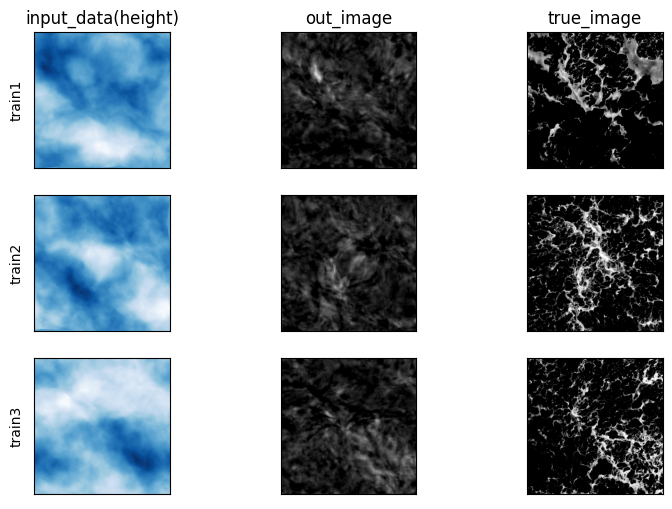

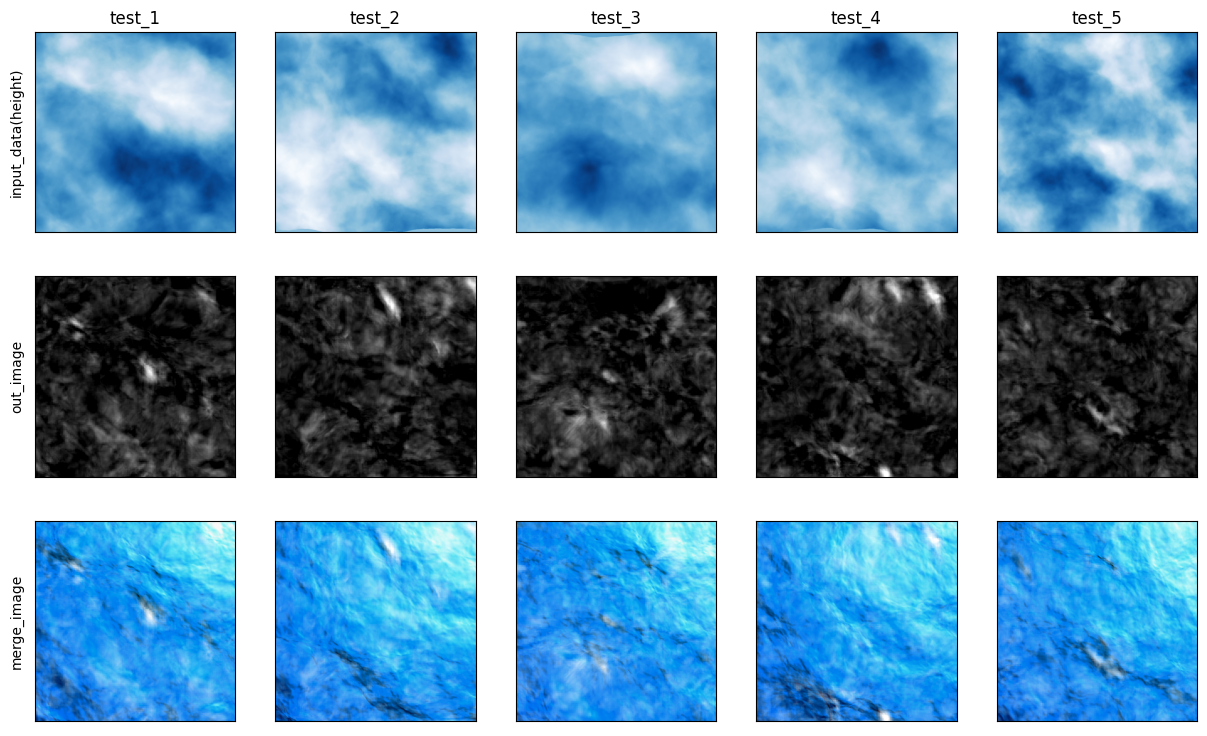

In [4]:
#画像データ前処理, 描画用
import numpy as np
import matplotlib.pyplot as plt
#機械学習
import tensorflow as tf
import tensorflowjs as tfjs

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
#通知の通信用
import requests
import random
from PIL import Image
import cv2
from tqdm import tqdm
import os



#0,1のgpuのうち片方を使う
def allocate_gpu_memory(gpu_number=0):
    physical_devices = tf.config.experimental.list_physical_devices('GPU')

    if physical_devices:
        try:
            print("Found {} GPU(s)".format(len(physical_devices)))
            tf.config.set_visible_devices(physical_devices[gpu_number], 'GPU')
            tf.config.experimental.set_memory_growth(physical_devices[gpu_number], True)
            print("#{} GPU memory is allocated".format(gpu_number))
        except RuntimeError as e:
            print(e)
    else:
        print("Not enough GPU hardware devices available")


def surface_load(path,OUTPUT_SIZE=1024):
    surface = np.fromfile(path, dtype=np.float32)
    surface=surface.reshape(OUTPUT_SIZE,OUTPUT_SIZE,4)
    surface=surface[::-1]
    return surface


def image_load(path,size,cutting_rate=0.05):
    img=tf.io.read_file(path)
    img=tf.image.decode_png(img, channels=4).numpy()
    margin=int(cutting_rate*size/2)
    img_clip=img[margin:size-margin,margin:size-margin,:]#画像の端を切る
    img_clip=img_clip/255
    img_resize=cv2.resize(img_clip,dsize=[1024]*2)
    return img_resize
def load_testsurface():
    #シミュレーションデータを5つロード
    OUTPUT_SIZE=1024
    n=5
    surface_other=[]
    for i in  range(1,n+1):
        surface_other.append(surface_load(f"surfacedata/oceandata_{i}.dat"))
    #シミュレーションの光学データ, 空撮のトーン変換画像を5つロード
    optics_other=[]
    optics_other_adjusted=[]
    for i in  range(1,n+1):
        optics_other.append(image_load(f"surfacedata/oceandata_{i}.png",1024,0))
        optics_other_adjusted.append(image_load(f"surfacedata/oceandata_{i}_adjust.png",1024,0))
    return surface_other, optics_other_adjusted




def genTrueImages(images,margin):
    #target_size=1024-margin*2#出力のサイズ(margin*2の分だけ縮小する)
    true_images=[]
    for img in images:
        img_clip=img[margin:-margin,margin:-margin]#画像をmarginの分だけクリッピング
        img_tf = tf.convert_to_tensor(img_clip[ None,:, :, 3], tf.float32)#imageの透明度部分
        true_images.append(img_tf)
    return true_images
    #print("before:",images[0].shape,"after:",true_images[0].shape)

def mergeRGBA(alpha_img):
    color_img=np.full((alpha_img.shape[0],alpha_img.shape[1],3),1.0)#White
    merge_img=np.concatenate([color_img,alpha_img],axis=2)
    return merge_img
def plotOceanHeight(data,axis,title,ticks_invisible=1):
    h=data
    h=(h-h.min())/(h.max()-h.min())
    axis.imshow(1-h, cmap='Blues', vmin=0, vmax=1)
    if (title != ""):
        axis.set_title(title)
    if ticks_invisible==1:
        axis.xaxis.set_ticks([])#軸の値を消去
        axis.yaxis.set_ticks([])
        
def plot_whiteimg(white_img,axis, title):
    axis.set_facecolor("black")#背景色を黒に
    axis.imshow(white_img)
    axis.set_title(title)
    axis.xaxis.set_ticks([])#軸の値を消去
    axis.yaxis.set_ticks([])

    
def reconstruct(model,text=["train1","train2","train3"]):
    out_imgs=[]
    m=0.2
    a=0.2
    f=lambda x:(1+a)*x/m-a
    for surface in surfaces:
        out = model.predict(surface[None, ..., :3])[0]#モデルからデコード
        #out=f(out)#ヒストグラム調整
        #out=np.clip(out,0,1)#0~1内に収める
        out_imgs.append(mergeRGBA(out))#白画像と透明度をマージした画像を格納
    
    print(out_imgs[0].shape,true_images[0][0].shape)#true_imagesがtensor形式であることに注意
    
    fig, axis = plt.subplots(3, 3, figsize=(3*3, 3*2))
    
    for i,surface, out_img in zip(range(3),surfaces,out_imgs):
        if i==0:#最初の行
            plotOceanHeight(surface[...,0],axis[i][0],"input_data(height)")
            plot_whiteimg(out_img,axis[i][1],"out_image")
            plot_whiteimg(mergeRGBA(true_images[i][0][...,None]),axis[i][2],"true_image")
        else:
            plotOceanHeight(surface[...,0],axis[i][0],"")
            plot_whiteimg(out_img,axis[i][1],"")
            plot_whiteimg(mergeRGBA(true_images[i][0][...,None]),axis[i][2],"")
        axis[0][0].set_ylabel(text[0])#行ごとにラベルを付与
        axis[1][0].set_ylabel(text[1])
        axis[2][0].set_ylabel(text[2])
    fig.show()
    #return out_imgs
def predict_otherdata(model,surface_other,optics_other_adjusted):
    test_n=5
    fig, axis = plt.subplots(3, test_n, figsize=(3*test_n, 3*3))
    target_size=margin
    #m=0.35
    #a=0.4
    #f=lambda x:(1+a)*x/m-a
    for i in range(test_n):    
        if i==0:
            axis[0][0].set_ylabel("input_data(height)")
            axis[1][0].set_ylabel("out_image")
            axis[2][0].set_ylabel("merge_image")
        out = model.predict(surface_other[i][None, ..., :3])[0]
        #out=f(out)#ヒストグラム調整
        out=np.clip(out,0,1)#0~1内に収める
        out_image=mergeRGBA(out)
        #optics_image=cv2.resize(optics_other_adjusted[i],dsize=[target_size]*2)#出力の大きさにリサイズ
        optics_image=optics_other_adjusted[i][margin:-margin,margin:-margin]#出力の大きさにリサイズ
        plotOceanHeight(surface_other[i][...,0],axis[0][i], f"test_{i+1}")
        plot_whiteimg(out_image,axis[1][i],"")
        axis[2][i].imshow(optics_image)
        plot_whiteimg(out_image,axis[2][i],"")#上の画像に重ねていることに注意
    #fig.savefig(f"./outputs/{note_title}/{identify}_test_all.png")
    fig.show()

def gauss2D(sigma=1.0):
    size = int(np.ceil(2 * sigma))
    gsize = 1 + 2 * size
    mesh = np.linspace(-2.0, 2.0, gsize)
    x, y = np.meshgrid(mesh, mesh)
    h = np.exp( -(x*x + y*y) / 2)
    return size, h / h.sum()


#2つのパスで畳み込みを繰り返すモデル(B:プーリングあり, A:プーリングなし)
def gen_model(layers, scale, lr, gauss=1.0):
    x = tf.keras.Input(shape=(None, None, 3))#入力

    #分岐B(プーリングを通りてぼかした処理)
    shrinksize=0
    B = tf.keras.layers.AveragePooling2D(
        pool_size=(scale, scale)
    )(x) #B1：入力画像のプーリング
    for i, (num, size) in enumerate(layers):
        B = tf.keras.layers.Conv2D(
            num, 2 * size + 1, activation='relu', name=f'cv2_B_{i+1}',
        )(B) #Bi:畳み込み
        shrinksize += size
    B = tf.keras.layers.UpSampling2D(
        size=(scale, scale)
    )(B) #Blast：畳み込み後の拡大

    gsize, gkernel = gauss2D(gauss)
    glayer = tf.keras.layers.DepthwiseConv2D(2 * gsize + 1, use_bias=False, name="gauss")
    B = glayer(B)
    glayer.set_weights([np.tile(gkernel[..., None, None], [1, 1, num, 1])])
    glayer.trainable= False
    
    diff = (shrinksize * scale + gsize) - shrinksize
    #分岐A(画像をそのまま処理)
    A = x
    kernel = np.zeros((1 + 2 * diff, 1 + 2 * diff))
    kernel[size, size] = 1
    crop = tf.keras.layers.DepthwiseConv2D(2 * diff + 1, use_bias=False, name=f'cv2_Acrop')
    A = crop(A)
    crop.set_weights([tf.tile(kernel[..., None, None], [1, 1, 3, 1])])
    crop.trainable= False
    '''
    clop = tf.keras.layers.Cropping2D(
        cropping=((diff, diff), (diff,diff))
    )
    '''
    for i, (num, size) in enumerate(layers):
        A = tf.keras.layers.Conv2D(
            num, 2 * size + 1, activation='relu', name=f'cv2_A_{i+1}',
        )(A) #Ai:畳み込み
    
    concat = tf.keras.layers.Concatenate()([A, B])#B,Aの分岐を繋ぐ
    output = tf.keras.layers.Conv2D(
        1, 1, activation='hard_sigmoid',name=f'cv2_comp',
    )(concat)#1チャネルにまとめる処理
    
    model = tf.keras.Model(inputs=x, outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        #loss=tf.keras.losses.MeanAbsoluteError(),
        loss=tf.keras.losses.MeanSquaredError(),
        #metrics=['accuracy'],
    )
    #model.summary()
    return model, shrinksize * scale + gsize #分岐Bのサイズだけ減る


def get_model(layer, s, lr=0.001, gauss=1.0):
    model, margin = gen_model(layers=layer, scale=s, lr=lr, gauss=gauss)
    model_name=f"n{len(layer)}_l{layer[0][1]}_s{s}_lr{lr}_m{margin}"#モデルの識別名(層の数_フィルタの最大のサイズ_スケール_学習率_マージン)
    new_dir_path=f"savedWeights/{model_name}"#重みを保存しているディレクトリ
    model.load_weights(f'{new_dir_path}/{model_name}_last.h5')#重みをロード  
    print('model_name',model_name)
    true_images=genTrueImages(images,margin)
    return model, true_images,margin


allocate_gpu_memory(0)

#2セットのデータをロード
surfaces_path=["surfacedata/oceandata_t1.dat","surfacedata/oceandata_t2.dat","surfacedata/oceandata_t3.dat"]
image_path=["imgdata/white_wave_rev.png","imgdata/white_wave2_rev.png","imgdata/white_wave3.png" ]
image_sizes=[2326,1023,1023]
cutting_rate=0.1
surfaces=[]
images=[]
for s_path  in surfaces_path:
    surfaces.append(surface_load(s_path))
for i_path,size in zip(image_path,image_sizes):
    images.append(image_load(i_path,size,cutting_rate))

model, true_images,margin = get_model([(20, 3), (20, 1)], 8, lr=0.0001, gauss=1)
reconstruct(model)

testsurface,testimg=load_testsurface()
predict_otherdata(model,testsurface,testimg)